In [1]:
import pandas as pd
import numpy as np

file_name_out='ENT_CA_DM_Meds_Outpatient.txt'
file_name_in='ENT_CA_DM_Meds_Inpatient.txt'
df_out=pd.read_csv(file_name_out,delimiter='|',error_bad_lines=False, parse_dates=True)
df_in=pd.read_csv(file_name_in,delimiter='|',error_bad_lines=False, parse_dates=True)
cols=['mrn', 'enc_date', 'thera_class', 'med_name', 'generic_name', 'pharm_class', 
      'order_start_dttm', 'order_end_dttm', 'order_med_freq', 'ordering_mode']
df_out=df_out[cols]
df_in=df_in[cols]
df=df_out.append(df_in)
print ('df size:',df.shape[0])


df size: 2000610


In [2]:
import re

def isChemoDrug(drug):
    try:
        drug_lower=drug.lower()
        drugs=['everolimus', 'hydroxyurea', 'nab-paclitaxel', 'paclitaxel', 
               'erlotinib', 'fluorouracil', 'cisplatin', 'cetuximab', 
               'docetaxel', 'carboplatin', 'nivolumab', 'pembrolizumab', 'methotrexate']
        pattern=r""
        for index,d in enumerate(drugs):
            if index==0:
                pattern=d
            else:
                pattern=pattern+'|'+d
        search=re.search(pattern,drug_lower)
        if search:
            return True
        else:
            return False
    except:
        return False

mask=df['med_name'].apply(isChemoDrug)
df=df[mask]
print ('df size with only chemo drugs:',df.shape[0])

df size with only chemo drugs: 105513


In [3]:
from datetime import datetime,timedelta

def time_elapsed(start_date,current_date):
    '''get difference between two datetimes'''
    time=current_date-start_date
    return time

def times_elapsed(df):
    '''from a sorted df with a datetime index get a list of how many days it has been since 1st encounter'''
    start_date=df.iloc[0]['enc_date'].to_pydatetime()
    times=[]
    for index,row in df.iterrows():
        current_date=row['enc_date'].to_pydatetime()
        time=time_elapsed(start_date,current_date)
        times.append(time.days)
    return times
def get_med(med_name):
    try:
        return med_name.split(' ')[0]
    except:
        return med_name


df['enc_date']=pd.to_datetime(df['enc_date'],infer_datetime_format=True)
df['order_start_dttm']=pd.to_datetime(df['order_start_dttm'],infer_datetime_format=True)
df['order_end_dttm']=pd.to_datetime(df['order_end_dttm'],infer_datetime_format=True)
df['med']=df.med_name.apply(get_med)

unique_mrns=df.mrn.unique()
print ('Number of unique ptx:',len(unique_mrns))

ptx_info=[]
for mrn in unique_mrns:
    sub_df=df[df['mrn']==mrn]
    ptx_info.append(sub_df)

### create a dict with keys of mrns and values of lists: [earliest date,latest date,df for only that ptx]
d={}
for index,ptx in enumerate(ptx_info):
    ptx_info[index]=ptx.sort_values(by=['enc_date','order_end_dttm'])
    times=times_elapsed(ptx_info[index])
    ptx_info[index]['days_elapsed']=times
    date_earliest=ptx_info[index].iloc[0]['enc_date']
    date_latest=ptx_info[index].iloc[-1]['enc_date']
    d[ptx.iloc[0]['mrn']]=[date_earliest,date_latest,ptx_info[index]]

practice_mrn=unique_mrns[2]
d[practice_mrn]

Number of unique ptx: 1229


[Timestamp('2009-11-03 00:00:00'),
 Timestamp('2012-03-02 00:00:00'),
              mrn   enc_date      thera_class                     med_name  \
 1141123  1420705 2009-11-03  ANTINEOPLASTICS                PACLITAXEL IV   
 1141124  1420705 2009-11-03  ANTINEOPLASTICS                PACLITAXEL IV   
 1162557  1420705 2009-11-03  ANTINEOPLASTICS  CARBOPLATIN AUC DOSING IVPB   
 1138964  1420705 2009-11-03  ANTINEOPLASTICS               CARBOPLATIN IV   
 1130476  1420705 2009-11-25  ANTINEOPLASTICS                PACLITAXEL IV   
 1151784  1420705 2009-11-25  ANTINEOPLASTICS                PACLITAXEL IV   
 1151785  1420705 2009-11-25  ANTINEOPLASTICS  CARBOPLATIN AUC DOSING IVPB   
 1151786  1420705 2009-11-25  ANTINEOPLASTICS  CARBOPLATIN AUC DOSING IVPB   
 1138967  1420705 2009-12-16  ANTINEOPLASTICS                PACLITAXEL IV   
 1141399  1420705 2009-12-16  ANTINEOPLASTICS                PACLITAXEL IV   
 1141216  1420705 2009-12-16  ANTINEOPLASTICS  CARBOPLATIN AUC DOSING IV

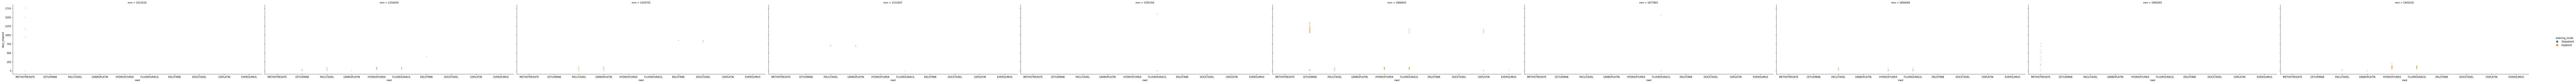

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
def graph_ptx(data,fig_name=''):
    '''Graph drugs by enc_date using date_elapsed, with choice of hue'''
    grid=sns.catplot(x='med', y="days_elapsed", hue='ordering_mode',jitter=False, 
                 **{'alpha':.8,'s':2},data=data, height=5, aspect=3,col='mrn',
                    )
    if fig_name != '':
        plt.savefig(fig_name)
mrns=unique_mrns[:10]
big_data=''
for index,mrn in enumerate(mrns):
    data=d[mrn][2]
    if index==0:
        big_data=data
    else:
        big_data=big_data.append(data)

graph_ptx(big_data)
#graph_ptx(big_data,'ordering_mode')

In [5]:
patient_med_timelines=[]
for i,num in enumerate(unique_mrns):
    df_prac=d[num][2]
    df_prac=df_prac.reset_index()
    data=[]
    try:
        for index,row in df_prac.iterrows():
            mrn_=row['mrn']
            med_=row['med']
            ordering_mode_=row['ordering_mode']
            if pd.isnull(row['order_start_dttm']):
                df_prac.at[index, 'order_start_dttm']= row['enc_date']
            if pd.isnull(row['order_end_dttm']):
                df_prac.at[index, 'order_end_dttm']= row['enc_date']
            days=pd.date_range(start=df_prac.iloc[index]['order_start_dttm'],end=df_prac.iloc[index]['order_end_dttm'])
            for day in days:
                data.append([mrn_,day,med_,ordering_mode_])
        ptx_df=pd.DataFrame(data,columns=['mrn','enc_date','med','ordering_mode'])
        times=times_elapsed(ptx_df)
        ptx_df['days_elapsed']=times
        patient_med_timelines.append(ptx_df)
    except:
        print('FAILURE, MRN:',num)
    print (str(i+1)+'/'+str(len(unique_mrns)))

1/1229
2/1229
3/1229
4/1229
5/1229
6/1229
7/1229
8/1229
9/1229
10/1229
11/1229
12/1229
13/1229
14/1229
15/1229
16/1229
17/1229
18/1229
19/1229
20/1229
21/1229
22/1229
23/1229
24/1229
25/1229
26/1229
27/1229
28/1229
29/1229
30/1229
31/1229
32/1229
33/1229
34/1229
35/1229
36/1229
37/1229
38/1229
39/1229
40/1229
41/1229
42/1229
43/1229
44/1229
45/1229
46/1229
47/1229
48/1229
49/1229
50/1229
51/1229
52/1229
53/1229
54/1229
55/1229
56/1229
57/1229
58/1229
59/1229
60/1229
61/1229
62/1229
63/1229
64/1229
65/1229
66/1229
67/1229
68/1229
69/1229
70/1229
71/1229
72/1229
73/1229
74/1229
75/1229
76/1229
77/1229
78/1229
79/1229
80/1229
81/1229
82/1229
83/1229
84/1229
85/1229
86/1229
87/1229
88/1229
89/1229
90/1229
91/1229
92/1229
93/1229
94/1229
95/1229
96/1229
97/1229
98/1229
99/1229
100/1229
101/1229
102/1229
103/1229
104/1229
105/1229
106/1229
107/1229
108/1229
109/1229
110/1229
111/1229
112/1229
113/1229
114/1229
115/1229
116/1229
117/1229
118/1229
119/1229
120/1229
121/1229
122/1229
123/1229
1

919/1229
920/1229
921/1229
922/1229
923/1229
924/1229
925/1229
926/1229
927/1229
928/1229
929/1229
930/1229
931/1229
932/1229
933/1229
934/1229
935/1229
936/1229
937/1229
938/1229
939/1229
940/1229
941/1229
942/1229
943/1229
944/1229
945/1229
946/1229
947/1229
948/1229
949/1229
950/1229
951/1229
952/1229
953/1229
954/1229
955/1229
956/1229
957/1229
958/1229
959/1229
960/1229
961/1229
962/1229
963/1229
964/1229
965/1229
966/1229
967/1229
968/1229
969/1229
970/1229
971/1229
972/1229
973/1229
974/1229
975/1229
976/1229
977/1229
978/1229
979/1229
980/1229
981/1229
982/1229
983/1229
984/1229
985/1229
986/1229
987/1229
988/1229
989/1229
990/1229
991/1229
992/1229
993/1229
994/1229
995/1229
996/1229
997/1229
998/1229
999/1229
1000/1229
1001/1229
1002/1229
1003/1229
1004/1229
1005/1229
1006/1229
1007/1229
1008/1229
1009/1229
1010/1229
1011/1229
1012/1229
1013/1229
1014/1229
1015/1229
1016/1229
1017/1229
1018/1229
1019/1229
1020/1229
1021/1229
1022/1229
1023/1229
1024/1229
1025/1229
1026/1229
1

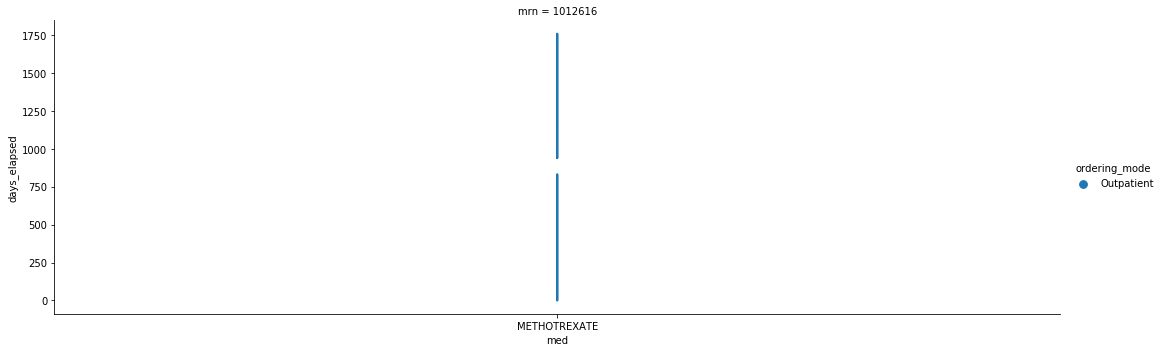

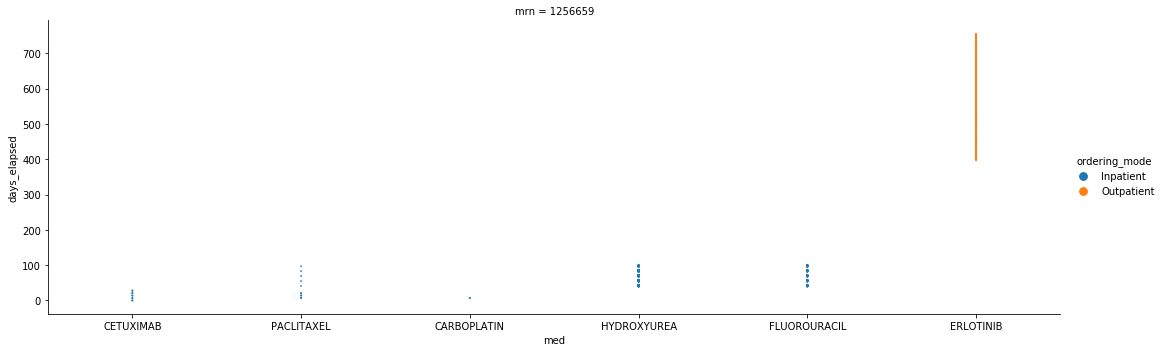

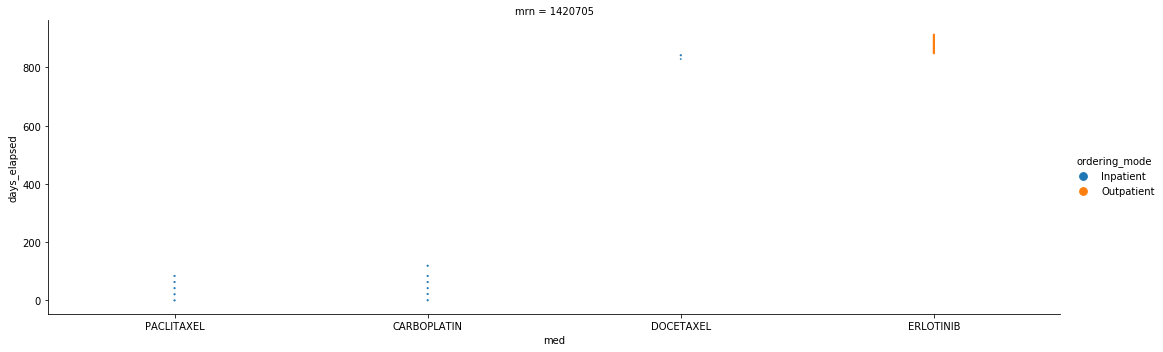

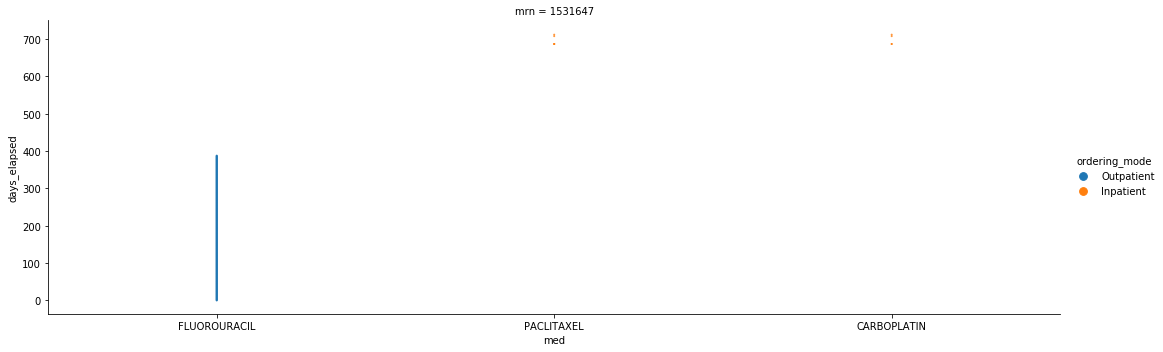

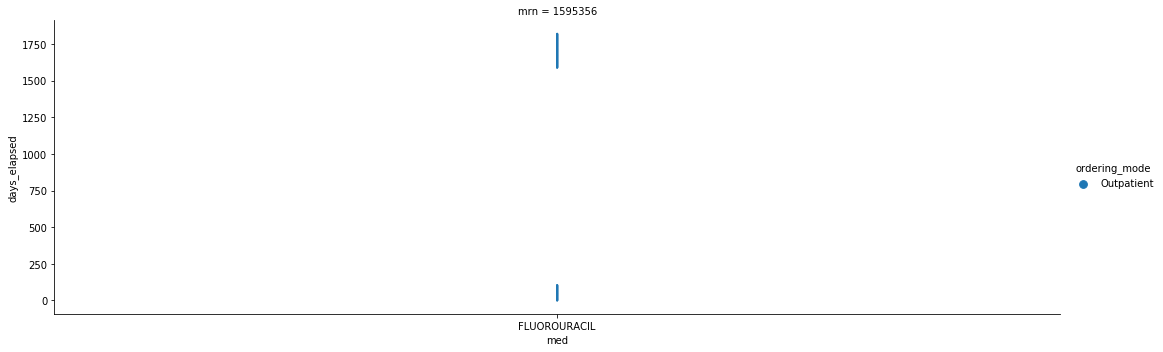

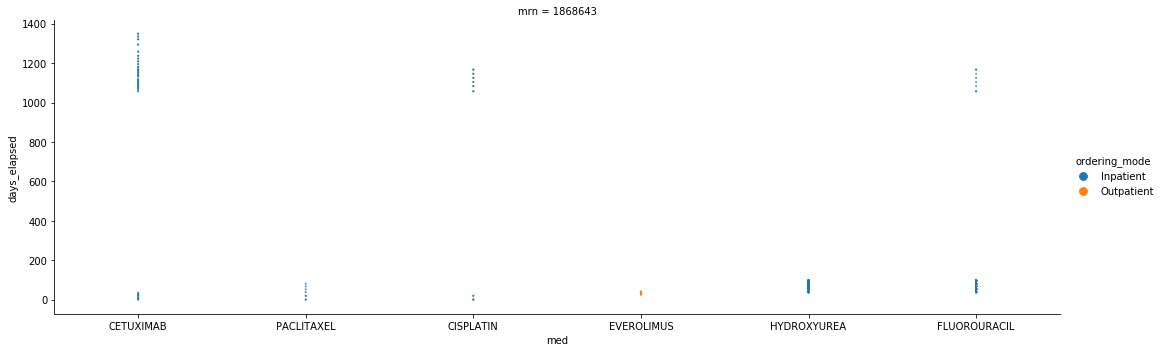

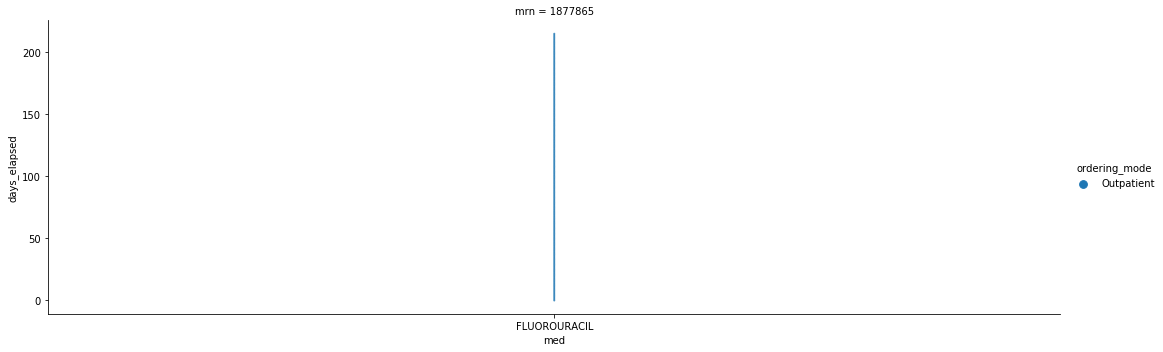

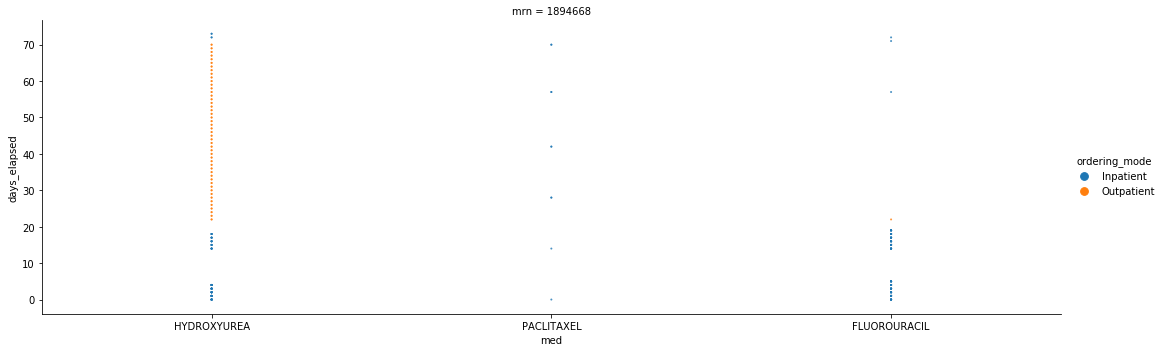

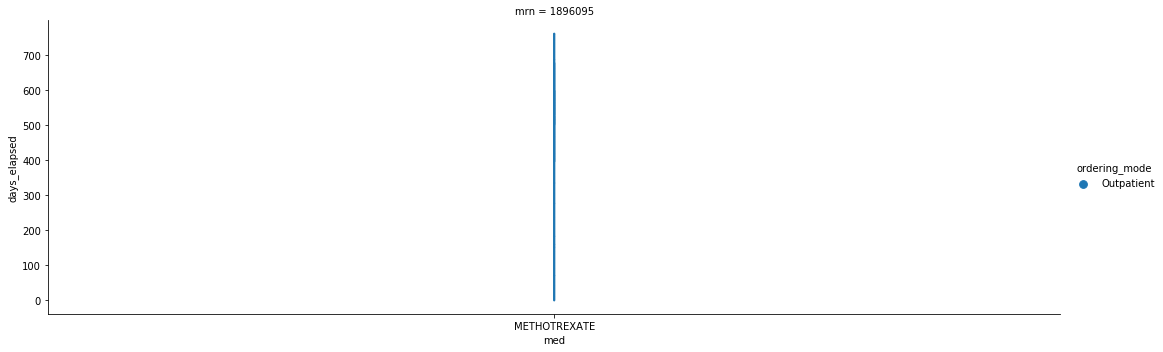

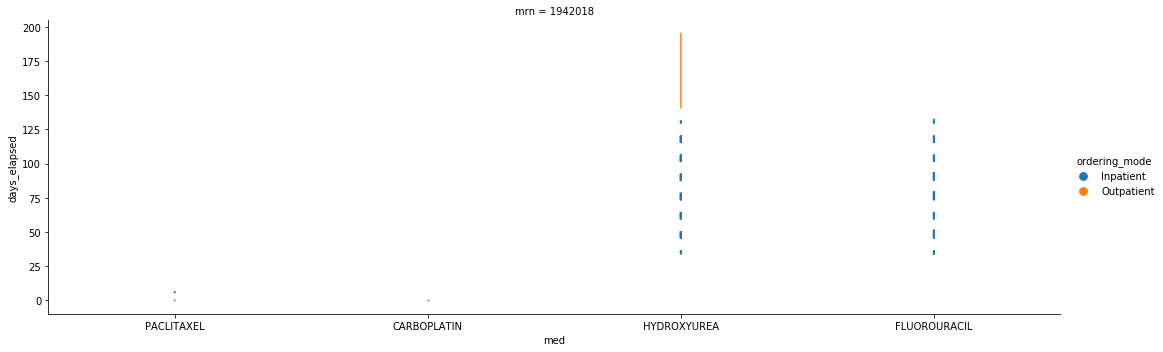

In [6]:
for num in range(10):
    fig_name='patient_med_timeline_'+str(num)
    graph_ptx(patient_med_timelines[num],fig_name=fig_name)

In [7]:
### filter mrns to only the ones from progress notes doc
mrn_df=pd.read_csv('HNDB Progress Notes Processed.csv')
mrns_to_use=mrn_df.mrn.unique()
print ('Number of target mrns:',len(mrns_to_use))

df_rebuilt=''
for index,ptx in enumerate(patient_med_timelines):
    if index==0:
        df_rebuilt=patient_med_timelines[index]
    else:
        df_rebuilt=df_rebuilt.append(patient_med_timelines[index])
df_rebuilt=df_rebuilt[df_rebuilt['mrn'].isin(mrns_to_use)]
print ('mrns in medication dataframe:',len(df_rebuilt['mrn'].unique()))

Number of target mrns: 171
mrns in medication dataframe: 154


In [8]:
print (df_rebuilt.columns)
cols=['enc_date','mrn']
df_export=df_rebuilt[cols]
df_export.to_csv('RM_med_dates.csv',index=False)

Index(['mrn', 'enc_date', 'med', 'ordering_mode', 'days_elapsed'], dtype='object')
